# Image Colorization

In [ ]:
# Project Outline

# 1 Imports
# 2 Data
# 3 Preprocessing 
# 4 Model 
# 5 Training
# 6 Evaluation
# 7 Visualization

In [6]:
# Imports
import numpy as np
import cv2
import torch
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

In [8]:
class ColorizationDataset(Dataset):
    def __init__(self, l_path, ab_paths):
        # Memory-mapped loading (DOES NOT load full files into RAM, instead adds pointer to disk)
        # Essentially a pointer to the file, where loaded 'slices' can be accessed like arr[idx]
       
        # Load L channel (0-255)
        self.l_data = np.load(l_path, mmap_mode="r")

        # Load ab files (0-255)
        self.ab_files = [np.load(path, mmap_mode="r") for path in ab_paths]

        # Combine metadata (pointers to memory-mapped arrays)
        self.ab_data = np.concatenate(self.ab_files, axis=0)

        # Lightness should be in the range of 0 to 100 for absolute black and absolute white respectively 
        print(type(self.l_data))
        print("L channel:", self.l_data.shape)
        print(self.l_data.max())
        print(self.l_data.min())
        
        # AB (Green-Magenta and Blue-Yellow) should be in the range of -128 to 127
        print("AB channel:", self.ab_data.shape)
        print(self.ab_data.max())
        print(self.ab_data.min())

        # Ensure image counts match
        assert self.l_data.shape[0] == self.ab_data.shape[0], "Mismatch in L and ab channel counts"

    def __len__(self):
        return self.l_data.shape[0]
    
    # Load a sample from disk into memory
    def __getitem__(self,idx):
        L = self.l_data[idx]             # shape: (224,224)
        ab = self.ab_data[idx]           # shape: (224,224,2)

        # Convert to Pytorch format (C, H, W)
        # Model expects:
            # L normalized to [0,1]
            # ab normalized to [-1,1]
        L = (L.astype("float32") / 255.0) 
        a = (ab[...,0].astype("float32") - 128) / 128  # 0–255 → -1 to +1
        b = (ab[...,1].astype("float32") - 128) / 128  # 0–255 → -1 to +1

        # Stack normalized AB channels: (H,W,2)
        ab_norm = np.stack([a, b], axis=-1)

        # Convert to channel first (Pytorch formatting again)
        L = L[np.newaxis, :, :]                       # (1,224,224)
        ab_norm = ab_norm.transpose(2, 0, 1)          # (2,224,224)

        # convert numpy arrays into torch.tensor objects
        return {
            'L': torch.tensor(L, dtype=torch.float32),
            'ab': torch.tensor(ab_norm, dtype=torch.float32)
        }
# Data (perhaps should be gradually read in to help with memory)
l_path = "Data/Raw/gray_scale.npy"
ab_paths = ["Data/Raw/ab/ab1.npy", "Data/Raw/ab/ab2.npy", "Data/Raw/ab/ab3.npy"]

# Create dataset
full_dataset = ColorizationDataset(l_path, ab_paths)


<class 'numpy.memmap'>
L channel: (25000, 224, 224)
255
0
AB channel: (25000, 224, 224, 2)
226
20


In [9]:
# Split into train/validation
val_size = int(0.1 * len(full_dataset))     # 10% for validation
train_size = len(full_dataset) - val_size   # 90% for training
train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size])

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True) # shuffle to avoid overfitting
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False) # don't shuffle to validate

In [10]:
#function to visualize an image
# convert model output --> RGB
def lab_to_rgb(L_norm, ab_norm):
    # undo normalization
    L = L_norm * 255
    a = ab_norm[...,0] * 128.0 + 128.0

    b = ab_norm[...,1] * 128.0 + 128.0

    #merge channels to create LAB
    lab = np.stack([L, a, b], axis=-1).astype("uint8")

    #convert LAB to color (rgb)
    rgb = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)
    rgb = np.clip(rgb / 255, 0, 1)
    return rgb

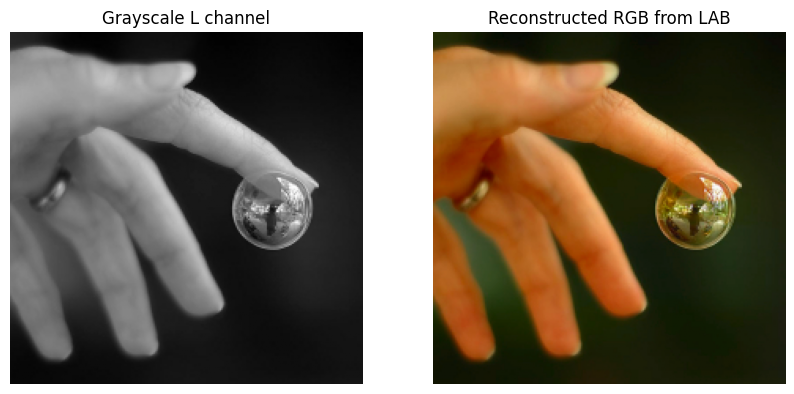

In [12]:
#display sample grayscale image

# Can choose any index
sample = full_dataset[354]      # loads single sample on demand

# Extract L and ab tensors
L_norm = sample['L'].numpy()[0]                   # (1,224,224) -> (244,244)
ab_norm = sample['ab'].numpy().transpose(1,2,0)   # (2,244,244) -> (224,224,2)

# Show the grayscale L channel

plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.imshow(L_norm, cmap="gray")
plt.title("Grayscale L channel")
plt.axis("off")

# Convert to RGB
rgb = lab_to_rgb(L_norm, ab_norm)

# Visualize
plt.subplot(1,2,2)
plt.imshow(rgb)
plt.title("Reconstructed RGB from LAB")
plt.axis("off")
plt.show()